## Step 1: Data Understanding & Initial Exploration

In [145]:
import pandas as pd

TATA_ds = pd.read_csv('/Users/hemamanohar/Downloads/Online Retail Data Set.csv', encoding='latin1')
# See all column names
print(list(TATA_ds.columns))
TATA_ds


['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France


In [147]:
#Preview the first few rows (including columns)
print(TATA_ds.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom  


In [149]:
#Get a summary of DataFrame structure
print(TATA_ds.shape)

(541909, 8)


In [151]:
# Check how many missing values per column
print(TATA_ds.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [153]:
# Check duplicates
print("Number of duplicates:", TATA_ds.duplicated().sum())

# Remove duplicates
df_nodup= TATA_ds.drop_duplicates()

Number of duplicates: 5268


In [155]:
#Missing customer IDs make it impossible to know who made a purchase, which isn’t useful for analysis.So we are droping it.
df = df_nodup.dropna(subset=['CustomerID'])

In [157]:
#mask_returns is a boolean Series that is True if the InvoiceNo starts with 'C' (which often indicates a product return in retail datasets)
mask_returns = df['InvoiceNo'].astype(str).str.startswith('C')
df = df[(df['Quantity'] >= 0) | mask_returns]

In [159]:
df = df[df['UnitPrice'] > 0]

In [161]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], dayfirst=True)

In [163]:
df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
df['UnitPrice'] = pd.to_numeric(df['UnitPrice'], errors='coerce')
df['CustomerID'] = pd.to_numeric(df['CustomerID'], errors='coerce')

## Step 2: Revenue Analysis

In [165]:
df = df.copy()
df['Revenue'] = df['Quantity'] * df['UnitPrice']
print("Total Revenue:", df['Revenue'].sum())

Total Revenue: 8278519.4240000015


In [167]:
#Group by Description, then aggregate Revenue three ways
summary_desc = df.groupby('Description')['Revenue'].agg(
    total_sales   = lambda x: x[x > 0].sum(),
    total_returns = lambda x: x[x < 0].sum(),
    net_revenue   = 'sum'
)
summarydesc=summary_desc.sort_values(by="net_revenue", ascending=False).head(10)
print(summarydesc)



                                    total_sales  total_returns  net_revenue
Description                                                                
REGENCY CAKESTAND 3 TIER              142264.75       -9697.05    132567.70
WHITE HANGING HEART T-LIGHT HOLDER    100392.10       -6624.30     93767.80
JUMBO BAG RED RETROSPOT                85040.54       -1984.02     83056.52
PARTY BUNTING                          68785.23       -1156.80     67628.43
POSTAGE                                77803.96      -11093.72     66710.24
ASSORTED COLOUR BIRD ORNAMENT          56413.03         -81.12     56331.91
RABBIT NIGHT LIGHT                     51251.24        -208.40     51042.84
CHILLI LIGHTS                          46265.11        -349.70     45915.41
PAPER CHAIN KIT 50'S CHRISTMAS         42584.13       -1160.35     41423.78
PICNIC BASKET WICKER 60 PIECES         39619.50           0.00     39619.50


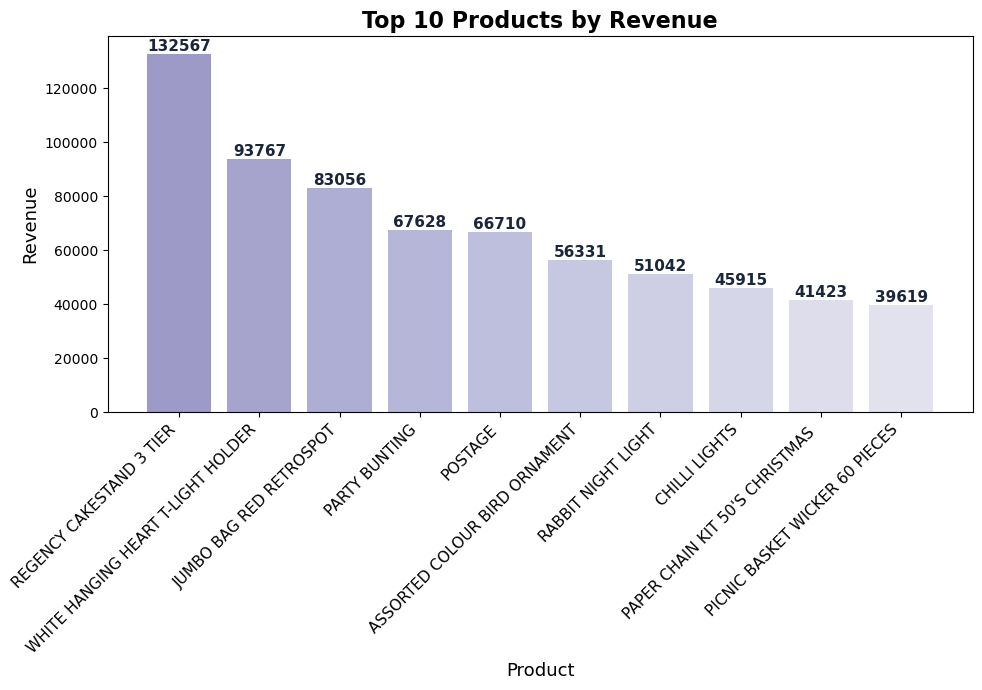

In [169]:
import matplotlib.pyplot as plt
import numpy as np

top_products = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,7))

# Use Blues colormap for blue shades (light to dark)
colors = plt.cm.Purples(np.linspace(0.5, 0.2, 10))  # Adjust range for nice blue variety

bars = plt.bar(top_products.index, top_products.values, color=colors)

# Add value labels on top of each bar
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(bar.get_height()),
             ha='center', va='bottom', fontsize=11, fontweight='bold', color='#1b263b')

plt.title('Top 10 Products by Revenue', fontsize=16, fontweight='bold')
plt.xlabel('Product', fontsize=13)
plt.ylabel('Revenue', fontsize=13)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [31]:
#df.groupby('Description') groups the data so all rows with the same Description are together.
#['Revenue'].sum() tells pandas to add up the Revenue column for each group.
#.reset_index() turns the result back into a normal DataFrame for easy viewing and further work.
#revenue_by_description now has two columns: Description and Revenue, showing total sales for each product.

#revenue_by_description = df.groupby('Description')['Revenue'].sum().sort_values()
#revenue_by_description


In [171]:
#Group by StockCode, then aggregate Revenue three ways
summary_code = df.groupby('StockCode')['Revenue'].agg(
    total_sales   = lambda x: x[x > 0].sum(),
    total_returns = lambda x: x[x < 0].sum(),
    net_revenue   = 'sum'
)
summarycode=summary_code.sort_values(by="net_revenue", ascending=False)
summarycode

,total_sales,total_returns,net_revenue
StockCode,,,
22423,142264.75,-9697.05,132567.70
85123A,100547.45,-6624.30,93923.15
85099B,85040.54,-1984.02,83056.52
47566,68785.23,-1156.80,67628.43
POST,77803.96,-11093.72,66710.24
...,...,...,...
79323W,0.00,-54.00,-54.00
22769,137.70,-225.50,-87.80
D,0.00,-5696.22,-5696.22


In [173]:
#Group by StockCode, then aggregate Revenue three ways
summary_country = df.groupby('Country')['Revenue'].agg(
    total_sales   = lambda x: x[x > 0].sum(),
    total_returns = lambda x: x[x < 0].sum(),
    net_revenue   = lambda x: x.sum() 
)
summarycountry=summary_country.sort_values(by="net_revenue", ascending=False)
summarycountry.head()

,total_sales,total_returns,net_revenue
Country,,,
United Kingdom,7285024.644,-537868.49,6747156.154
Netherlands,285446.340,-784.80,284661.540
EIRE,265262.460,-15260.68,250001.780
Germany,228678.400,-7168.93,221509.470
France,208934.310,-12308.26,196626.050


In [175]:
summarycountry=summary_country.sort_values(by="net_revenue")
summarycountry.head()

,total_sales,total_returns,net_revenue
Country,,,
Saudi Arabia,145.92,-14.75,131.17
Bahrain,548.40,0.00,548.40
Czech Republic,826.74,-119.02,707.72
RSA,1002.31,0.00,1002.31
Brazil,1143.60,0.00,1143.60


## Step 3: Operations Perspective


Quarterly Revenue Breakdown:
  Quarter  total_sales  net_revenue
1  2011Q1  1608267.990  1487842.180
2  2011Q2  1805775.531  1679096.861
3  2011Q3  2193704.143  2117546.643
4  2011Q4  2709038.500  2441660.880


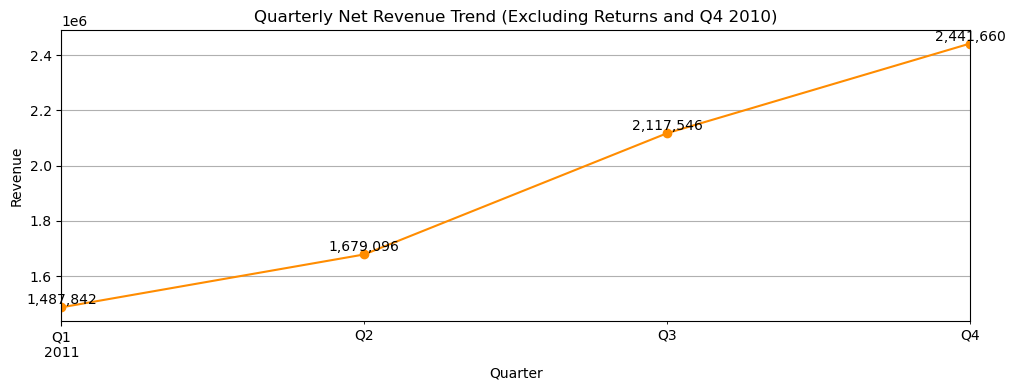

In [177]:
df['Quarter'] = df['InvoiceDate'].dt.to_period('Q')

quarterly_summary = df.groupby('Quarter')['Revenue'].agg(
    total_sales = lambda x: x[x > 0].sum(),
    net_revenue = 'sum'
).reset_index()

quarterly_summary = quarterly_summary[quarterly_summary['Quarter'] != '2010Q4']

print("\nQuarterly Revenue Breakdown:")
print(quarterly_summary)

quarterly_sales = quarterly_summary.set_index('Quarter')['net_revenue']

plt.figure(figsize=(10,4))
quarterly_sales.plot(kind='line', marker='o', color='darkorange')
plt.title('Quarterly Net Revenue Trend (Excluding Returns and Q4 2010)')
plt.xlabel('Quarter')
plt.ylabel('Revenue')
plt.grid(True)
plt.tight_layout()
for x, y in zip(quarterly_sales.index.astype(str), quarterly_sales.values):
    plt.text(x, y, f'{int(y):,}', ha='center', va='bottom', fontsize=10, color='black')
plt.show()



In [179]:
# Count unique orders per customer and rename the column
orders_per_customer = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'num_orders'})
print("orders_per_customer columns:", orders_per_customer.columns)

# Aggregate sales/returns/revenue
customer_summary = df.groupby('CustomerID')['Revenue'].agg(
    total_sales   = lambda x: x[x > 0].sum(),
    total_returns = lambda x: x[x < 0].sum(),
    net_revenue   = 'sum'
).reset_index()

# Merge on CustomerID
customer_summary = customer_summary.merge(orders_per_customer, on='CustomerID', how='left')
print("customer_summary columns:", customer_summary.columns)

orders_per_customer columns: Index(['CustomerID', 'num_orders'], dtype='object')
customer_summary columns: Index(['CustomerID', 'total_sales', 'total_returns', 'net_revenue',
       'num_orders'],
      dtype='object')


In [181]:
# Now calculate AOV
customer_summary['avg_order_value'] = customer_summary['net_revenue'] / customer_summary['num_orders']

# Show top 5 customers by net revenue
top5_customers = customer_summary.sort_values('net_revenue', ascending=False).head(5)
print(top5_customers[['CustomerID', 'num_orders', 'avg_order_value', 'total_sales', 'total_returns', 'net_revenue']])


      CustomerID  num_orders  avg_order_value  total_sales  total_returns  \
1702     14646.0          76      3677.487105    280206.02        -717.00   
4232     18102.0          62      4136.104677    259657.30       -3218.81   
3757     17450.0          55      3405.857636    194390.79       -7068.62   
1894     14911.0         248       534.107782    143711.17      -11252.44   
55       12415.0          26      4758.671154    124914.53       -1189.08   

      net_revenue  
1702    279489.02  
4232    256438.49  
3757    187322.17  
1894    132458.73  
55      123725.45  


In [183]:
# Now calculate AOV
customer_summary['avg_order_value'] = customer_summary['net_revenue'] / customer_summary['num_orders']

# Show top 5 customers by number of orders
top5_cust_orders = customer_summary.sort_values('num_orders', ascending=False).head(5)
print(top5_cust_orders[['CustomerID', 'num_orders', 'avg_order_value', 'total_sales', 'total_returns', 'net_revenue']])


      CustomerID  num_orders  avg_order_value  total_sales  total_returns  \
1894     14911.0         248       534.107782    143711.17      -11252.44   
330      12748.0         223       127.379193     33053.19       -4647.63   
4041     17841.0         169       235.911538     40519.84        -650.79   
1673     14606.0         128        90.885547     12076.15        -442.80   
568      13089.0         118       485.780763     58762.08       -1439.95   

      net_revenue  
1894    132458.73  
330      28405.56  
4041     39869.05  
1673     11633.35  
568      57322.13  


## Step 4: Marketing Effectiveness

In [185]:
# First and last purchase date for each customer
customer_dates = df.groupby('CustomerID')['InvoiceDate'].agg(first_purchase = 'min', 
                                                              last_purchase = 'max', 
                                                              purchase_days = 'nunique').reset_index()

# Flag repeat customers (more than 1 purchase date)
customer_dates['is_repeat'] = customer_dates['purchase_days'] > 1

print(customer_dates.head())

   CustomerID      first_purchase       last_purchase  purchase_days  \
0     12346.0 2011-01-18 10:01:00 2011-01-18 10:17:00              2   
1     12347.0 2010-12-07 14:57:00 2011-12-07 15:52:00              7   
2     12348.0 2010-12-16 19:09:00 2011-09-25 13:13:00              4   
3     12349.0 2011-11-21 09:51:00 2011-11-21 09:51:00              1   
4     12350.0 2011-02-02 16:01:00 2011-02-02 16:01:00              1   

   is_repeat  
0       True  
1       True  
2       True  
3      False  
4      False  


In [187]:
df['first_purchase_month'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')
cohort_counts = df.groupby(['first_purchase_month', df['InvoiceDate'].dt.to_period('M')])['CustomerID'].nunique().unstack(0).fillna(0)
print(cohort_counts.head(15))

first_purchase_month  2010-12  2011-01  2011-02  2011-03  2011-04  2011-05  \
InvoiceDate                                                                  
2010-12                 948.0      0.0      0.0      0.0      0.0      0.0   
2011-01                 362.0    421.0      0.0      0.0      0.0      0.0   
2011-02                 317.0    101.0    380.0      0.0      0.0      0.0   
2011-03                 367.0    119.0     94.0    440.0      0.0      0.0   
2011-04                 341.0    102.0     73.0     84.0    299.0      0.0   
2011-05                 376.0    138.0    106.0    112.0     68.0    279.0   
2011-06                 360.0    126.0    102.0     96.0     66.0     66.0   
2011-07                 336.0    110.0     94.0    102.0     63.0     48.0   
2011-08                 336.0    108.0     97.0     78.0     62.0     48.0   
2011-09                 374.0    131.0    107.0    116.0     71.0     60.0   
2011-10                 354.0    146.0     98.0    105.0     69.

In [189]:
num_repeat = customer_dates['is_repeat'].sum()
num_customers = customer_dates.shape[0]
retention_rate = num_repeat / num_customers
print(f"Retention Rate: {retention_rate:.2%}")


Retention Rate: 69.96%


In [191]:
# Total revenue per customer
clv = df.groupby('CustomerID')['Revenue'].sum().reset_index().rename(columns={'Revenue': 'lifetime_value'})
clv['lifetime_value'] = clv['lifetime_value'].round(2)

# Average CLV across all customers
avg_clv = clv['lifetime_value'].mean()
print(f"Average CLV: {avg_clv:.2f}")


Average CLV: 1893.96


In [193]:
from operator import attrgetter

#  Merge in first_purchase & last_purchase dates
clv = (
    clv
    .merge(customer_dates[['CustomerID','first_purchase','last_purchase']], on='CustomerID')
)

#  Compute “customer_age_months”
clv['age_months'] = (
    (clv['last_purchase'].dt.to_period('M')
     - clv['first_purchase'].dt.to_period('M'))
    .apply(attrgetter('n'))
    + 1  # include the cohort month itself
)

# Dollars per month of relationship
clv['CLV_per_month'] = clv['lifetime_value'] / clv['age_months']

# View the first few rows
print(clv[['CustomerID','lifetime_value','age_months','CLV_per_month']].head())


   CustomerID  lifetime_value  age_months  CLV_per_month
0     12346.0            0.00           1       0.000000
1     12347.0         4310.00          13     331.538462
2     12348.0         1797.24          10     179.724000
3     12349.0         1757.55           1    1757.550000
4     12350.0          334.40           1     334.400000


## Step 5: Demographic Analysis

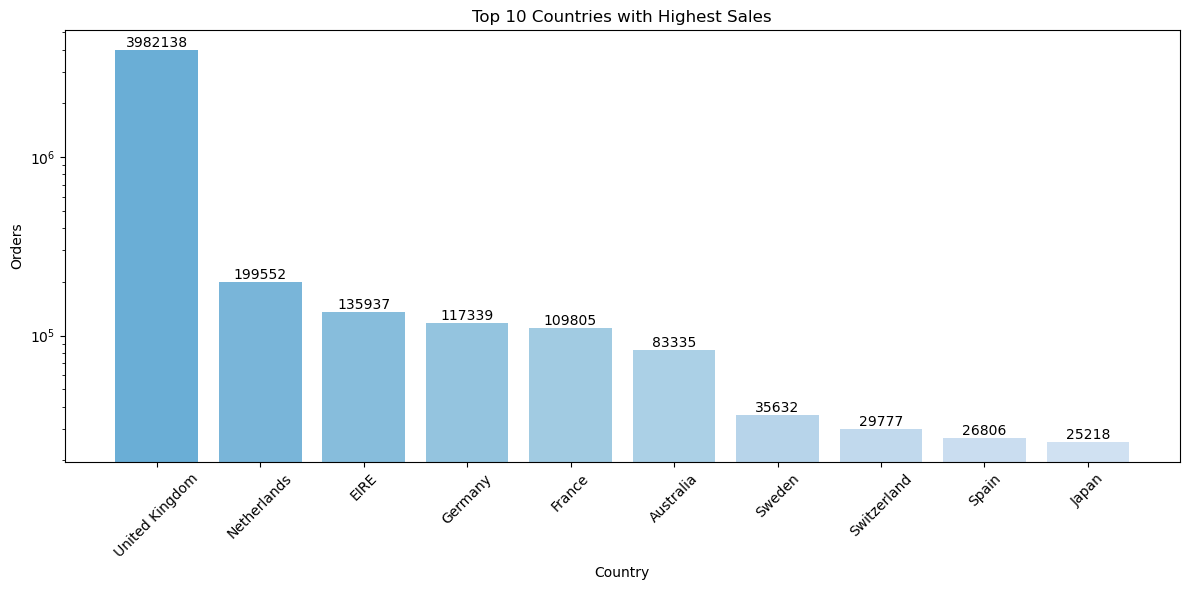

In [195]:
import matplotlib.pyplot as plt

# Top N countries (optional)
N = 10
Sales_across_country = df.groupby('Country')['Quantity'].sum().sort_values(ascending=False).head(N)

plt.figure(figsize=(12,6))
bars = plt.bar(Sales_across_country.index, Sales_across_country.values, color=plt.cm.Blues(np.linspace(0.5, 0.2, 10)))

# Set log scale for Y axis
plt.yscale('log')

# Add quantity labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}', 
             ha='center', va='bottom', fontsize=10)

plt.title('Top 10 Countries with Highest Sales')
plt.xlabel('Country')
plt.ylabel('Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


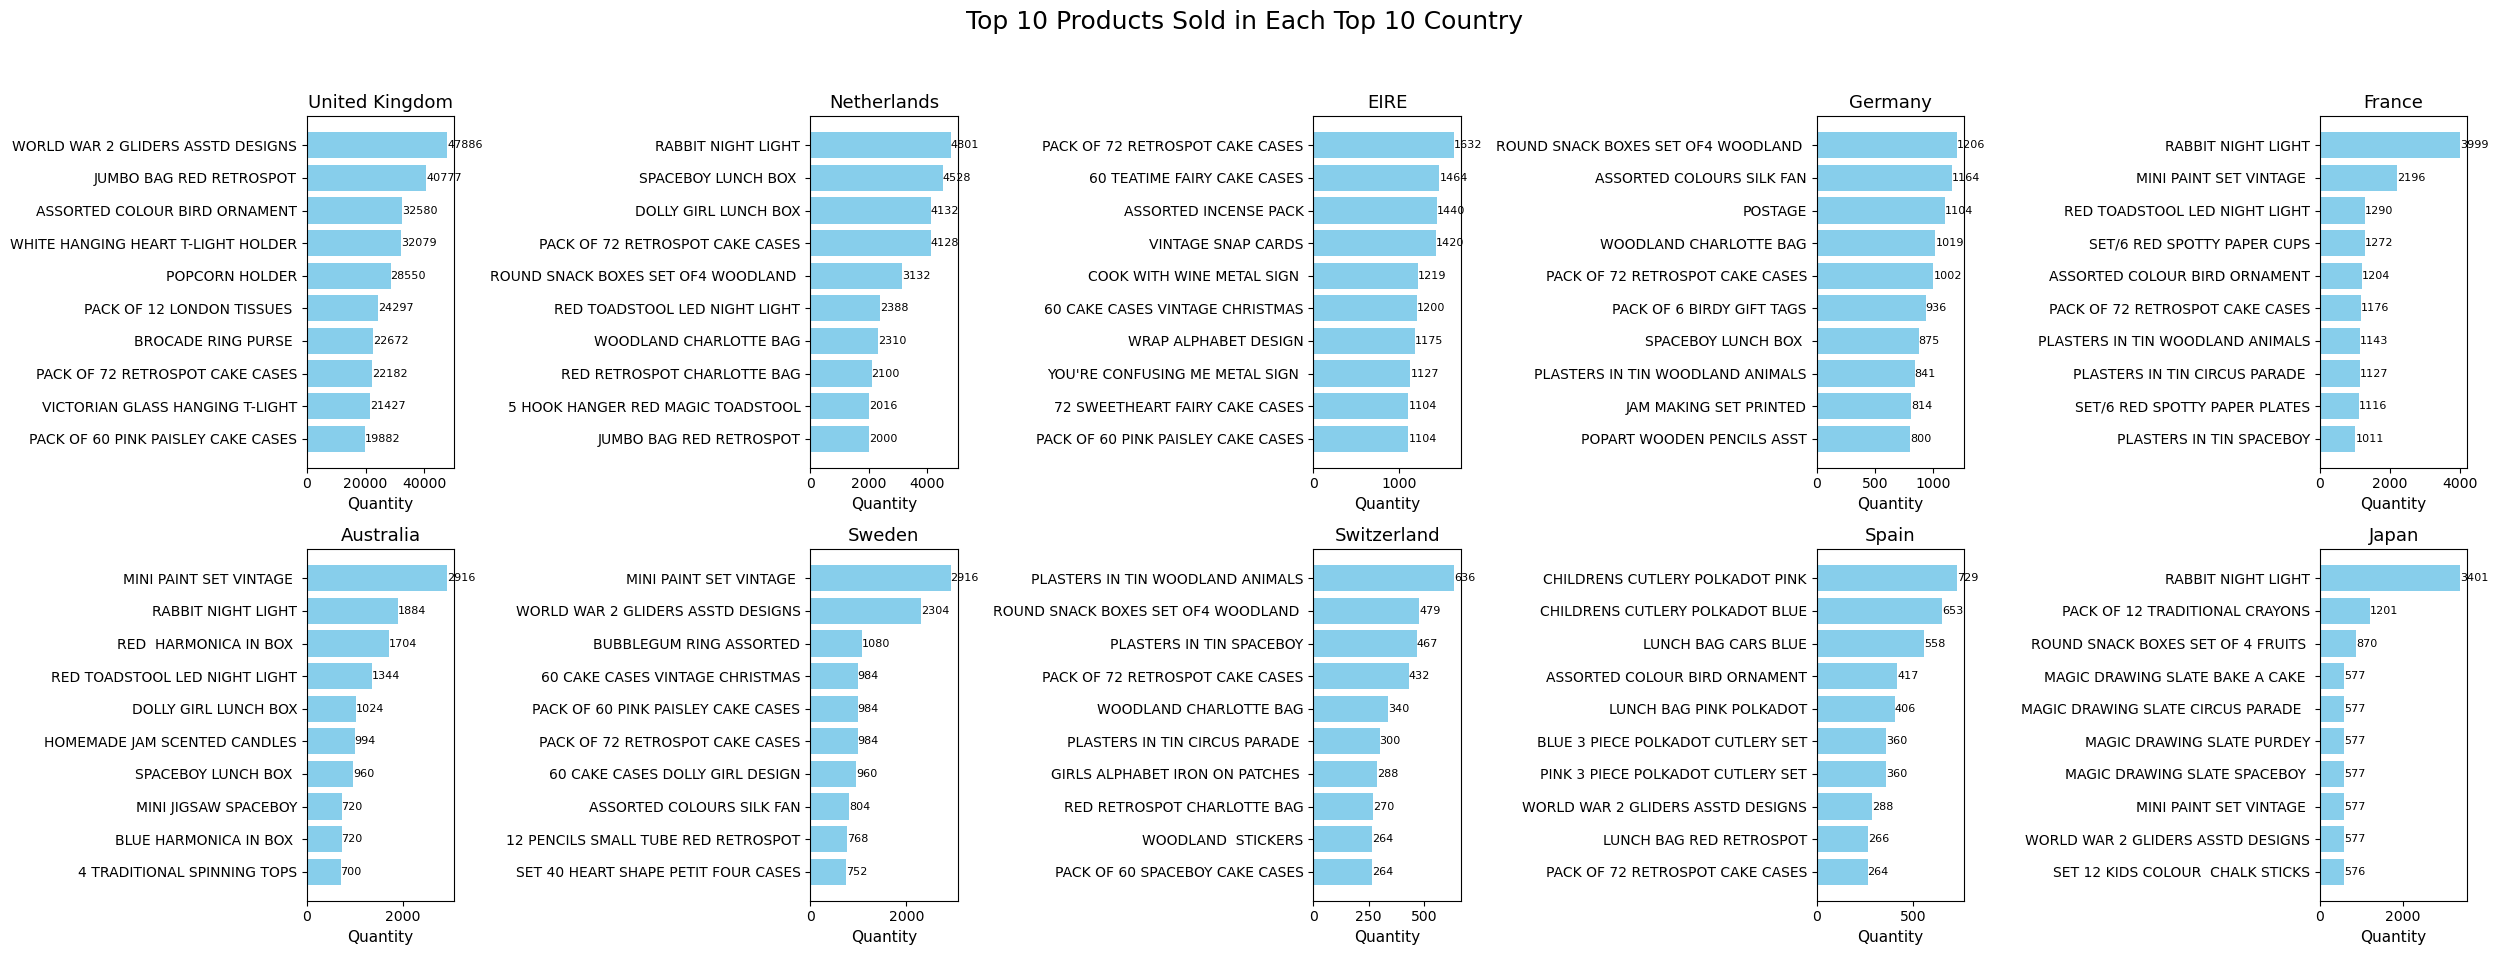

In [197]:
import matplotlib.pyplot as plt

# List of top 10 countries 
top_countries = ['United Kingdom', 'Netherlands', 'EIRE', 'Germany', 'France', 
                 'Australia', 'Sweden', 'Switzerland', 'Spain', 'Japan']

fig, axes = plt.subplots(2, 5, figsize=(25, 10))  # 2 rows, 5 columns

for idx, country in enumerate(top_countries):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    # Filter data for this country
    df_country = df[df['Country'] == country]
    # Group by product, get top 10 by quantity sold
    top_products = df_country.groupby('Description')['Quantity'].sum().sort_values(ascending=True).tail(10)
    
    bars = ax.barh(top_products.index, top_products.values, color='skyblue')
    ax.set_title(country, fontsize=13)
    ax.set_xlabel('Quantity', fontsize=11)
    
    # Add quantity labels at the end of each bar
    for bar in bars:
        ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
                int(bar.get_width()), ha='left', va='center', fontsize=8)
    
    # remove grid lines for clean look
    ax.grid(False)

plt.suptitle('Top 10 Products Sold in Each Top 10 Country', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Step 6: RFM and Basket Analysis

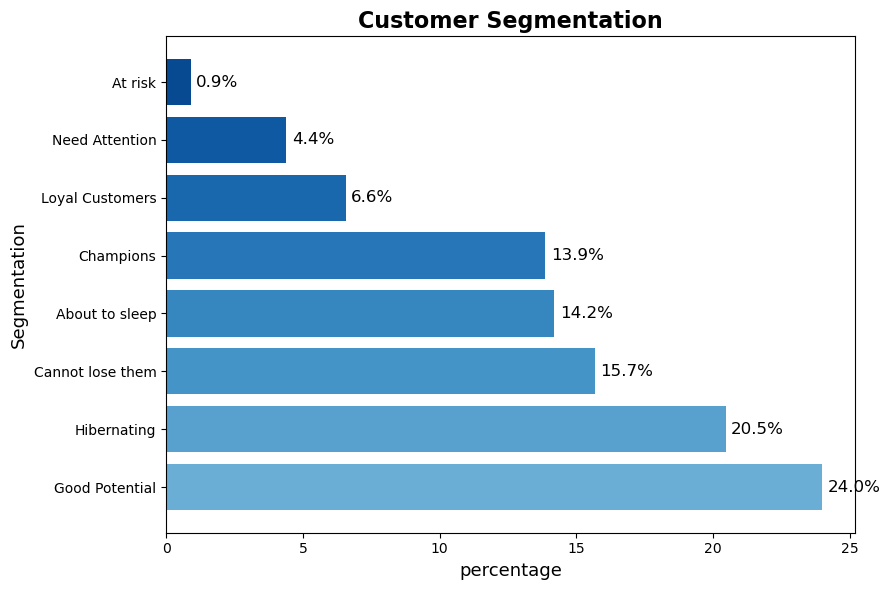

In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Calculate RFM
NOW = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                          # Frequency
    'Revenue': 'sum'                                 # Monetary
}).reset_index()
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Assign R, F, M scores from 1 (worst) to 4 (best)
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1]).astype(int)
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1,2,3,4]).astype(int)
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4]).astype(int)

# Combine scores into a string segment
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str) 

def rfm_segment(row):
    if row['R'] == 4 and row['F'] == 4: # Most recent, most frequent
        return 'Champions'
    elif row['R'] == 4 and row['F'] >= 3: # Recent, frequent
        return 'Loyal Customers'
    elif row['R'] >= 3 and row['F'] >= 2: # Reasonably recent and/or frequent
        return 'Good Potential'
    elif row['R'] == 1 and row['F'] == 4: # Not recent, but used to buy a lot
        return 'At risk'
    elif row['R'] == 1 and row['F'] <= 2: # Not recent, rarely buys
        return 'Hibernating'
    elif row['R'] == 2 and row['F'] <= 2: # Low activity, becoming inactive
        return 'About to sleep'
    elif row['R'] == 3 and row['F'] == 1: # Moderately recent, rarely buys
        return 'Need Attention'
    else:                                 # Important, but don’t fit above
        return 'Cannot lose them'

rfm['Segment'] = rfm.apply(rfm_segment, axis=1)

# Calculate segment percentages
segment_counts = rfm['Segment'].value_counts(normalize=True).sort_values(ascending=False) * 100

# Plot
plt.figure(figsize=(9,6))
bars = plt.barh(segment_counts.index, segment_counts.values, color=plt.cm.Blues(np.linspace(0.5, 0.9, len(segment_counts))))
for bar, value in zip(bars, segment_counts.values):
    plt.text(bar.get_width()+0.2, bar.get_y() + bar.get_height()/2, f"{value:.1f}%", va='center', fontsize=12)
plt.xlabel('percentage', fontsize=13)
plt.ylabel('Segmentation', fontsize=13)
plt.title('Customer Segmentation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()




In [201]:

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Prepare data for basket analysis (group product descriptions per InvoiceNo)
basket = df.groupby('InvoiceNo')['Description'].apply(list)

te = TransactionEncoder()
te_ary = te.fit_transform(basket)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(basket_df, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head())


                         antecedents                      consequents  \
370  (SET/6 RED SPOTTY PAPER PLATES)    (SET/6 RED SPOTTY PAPER CUPS)   
371    (SET/6 RED SPOTTY PAPER CUPS)  (SET/6 RED SPOTTY PAPER PLATES)   
357       (REGENCY TEA PLATE GREEN )       (REGENCY TEA PLATE ROSES )   
356       (REGENCY TEA PLATE ROSES )       (REGENCY TEA PLATE GREEN )   
337      (POPPY'S PLAYHOUSE KITCHEN)     (POPPY'S PLAYHOUSE BEDROOM )   

      support  confidence       lift  
370  0.010637    0.726154  56.527892  
371  0.010637    0.828070  56.527892  
357  0.010457    0.843636  55.049754  
356  0.010457    0.682353  55.049754  
337  0.011494    0.730659  50.816305  


In [162]:
# Sort rules by lift and take top N
top_rules = rules.sort_values(by='lift', ascending=False).head(10).copy()

# Convert frozensets to readable strings
top_rules['antecedents'] = top_rules['antecedents'].apply(lambda x: ', '.join(list(x)))
top_rules['consequents'] = top_rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Select and rename columns for clarity
top_rules = top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
top_rules.columns = ['If Buy', 'Then Buy', 'Support', 'Confidence', 'Lift']

# Format floats to 2 decimals for readability
top_rules['Support'] = top_rules['Support'].round(2)
top_rules['Confidence'] = top_rules['Confidence'].round(2)
top_rules['Lift'] = top_rules['Lift'].round(2)

# Reset index for a clean table look
top_rules = top_rules.reset_index(drop=True)

# Display the result
print(top_rules.to_string(index=False))


                                                  If Buy                                                 Then Buy  Support  Confidence  Lift
                                  REGENCY TEA PLATE PINK                                 REGENCY TEA PLATE GREEN      0.01        0.90 61.90
                                REGENCY TEA PLATE GREEN                                    REGENCY TEA PLATE PINK     0.01        0.75 61.90
                           POPPY'S PLAYHOUSE LIVINGROOM     POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE BEDROOM      0.01        0.74 53.85
   POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE BEDROOM                             POPPY'S PLAYHOUSE LIVINGROOM      0.01        0.73 53.85
                                  REGENCY MILK JUG PINK                                  REGENCY SUGAR BOWL GREEN     0.01        0.76 52.37
                                REGENCY SUGAR BOWL GREEN                                   REGENCY MILK JUG PINK      0.01        0.77 52.37
             


# Key Findings

## 1. Product Revenue Concentration
- The top three products—**PAPER CRAFT, LITTLE BIRDIE**; **REGENCY CAKESTAND 3 TIER**; and **WHITE HANGING HEART T-LIGHT HOLDER**—generate over half of the revenue among the top ten products, contributing approximately **4.6% of total company revenue**.
- This demonstrates that a small set of products have an outsized impact on overall sales.

## 2. Geographic Revenue Distribution
- **Revenue is highly concentrated in the United Kingdom**, which alone accounts for about **£6.7 million** or **76% of total sales**.
- Other notable markets—Netherlands (£284,661), EIRE/Ireland (£250,002), Germany (£221,509), and France (£196,626)—contribute much less in comparison, with most other countries having minimal impact.

## 3. Quarterly Revenue Trends
- The company experienced **steady and significant revenue growth throughout 2011**, with net revenue rising from **£1.6 million in Q1 to £2.7 million in Q4**.
- The highest sales were achieved in Q4, indicating strong seasonality likely driven by holidays and year-end promotions.

## 4. Customer Segmentation
- The largest customer segments are **"Good Potential"** (23.9%) and **"Hibernating"** (20.8%), indicating opportunities for reactivation and growth.
- **"Champions"** (14.0%) and **"Cannot lose them"** (16.0%) are high-value customers who should be prioritized for retention efforts.
- Smaller segments like **"At risk"** (0.6%) and **"Need Attention"** (4.3%) require targeted re-engagement to prevent churn.

## 5. Basket (Product Association) Analysis
- Strong product associations exist within the **Regency Tea Plate** and **Poppy’s Playhouse** lines.
- For example, customers who buy "REGENCY TEA PLATE PINK" have a **90% probability** of also buying "REGENCY TEA PLATE GREEN".
- These associations provide opportunities for cross-selling and bundling.

---

# Recommendations

1. **Maximize Revenue from Top Products**
   - Focus marketing and inventory on top-performing products.
   - Consider introducing similar or complementary products to expand success.

2. **Concentrate Resources in High-Performing Markets**
   - Allocate most sales, marketing, and operational resources to the UK.
   - Develop targeted strategies for the Netherlands, Ireland, Germany, and France.

3. **Leverage Seasonality**
   - Prepare for the Q4 sales surge with targeted promotions and adequate stock.
   - Use seasonal trends to plan marketing campaigns and optimize logistics.

4. **Customer Engagement & Retention**
   - Implement loyalty programs and exclusive offers for “Champions” and “Cannot lose them”.
   - Nurture “Good Potential” and “Hibernating” customers with personalized campaigns.
   - Re-engage “At risk” and “Need Attention” segments with targeted outreach.

5. **Enhance Cross-Selling and Bundling**
   - Promote bundles and “frequently bought together” offers for strongly associated products.
   - Use these insights in digital marketing and checkout recommendations to boost average order value.

---

# Summary:  
By focusing on best-selling products and the UK market, leveraging seasonality, and using data-driven customer segmentation and product association strategies, the company can further increase revenue and strengthen customer loyalty.
